# LVM Guide Star Catalog using the new library

In [40]:
import lvmguiding
import numpy as np
import os
import matplotlib.pyplot as plt
import time
from astropy.coordinates import SkyCoord
from importlib import reload
from matplotlib.colors import LogNorm
import matplotlib
import healpy as hp
from astropy.io import fits
import astropy.units as u
import scipy.spatial
from matplotlib.patches import Ellipse

In [2]:
import sys
sys.path.insert(1, 'lvmifusim/')
import IFU

In [17]:
reload(lvmguiding)

<module 'lvmguiding' from '/home/haeberle/Projects/LVM/LVM_Guide_Stars/lvmguiding/lvmguiding.py'>

In [4]:
lvmguiding.cat_full.shape

(157645865,)

In [11]:
irdc_data = np.loadtxt("target_db_run072021a_v2.tbl",skiprows=1)

## Creating the pointing list

In [12]:
!pwd

/home/haeberle/Projects/LVM/LVM_Guide_Stars/lvmguiding


## Making some example plots

In [13]:
irdc_data.shape

(83, 9)

In [8]:

#The old dark list... Let's do not use that anymore
darks_coordinates = np.loadtxt("southern_darks.ascii")
dark_index = 0 #Pick which of the southern darks you want to use
ra_irdc = darks_coordinates[dark_index,1]
dec_irdc = darks_coordinates[dark_index,2]
#coordinates_dark = SkyCoord(darks_coordinates[dark_index,1],darks_coordinates[dark_index,2],unit="deg")

#print(coordinates_dark)

In [77]:
#What is going on at <SkyCoord (ICRS): (ra, dec) in deg
#    (80.01870621, -68.35233157)>

#coordinates_crowded = SkyCoord(270.48085943, -28.45945724,unit="deg")
#coordinates_median = SkyCoord(195.10462204, -55.248677,unit="deg")
#coordinates_empty = SkyCoord(184.18604651, 15.16853933,unit="deg")

irdc_index =0

irdc_identifier = int(irdc_data[irdc_index,0])

ra_irdc = irdc_data[irdc_index,1]
dec_irdc = irdc_data[irdc_index,2]


print("Identifier: ",irdc_identifier)
print("Coordinates: ",ra_irdc,dec_irdc)
print("Radius: ",irdc_data[irdc_index,7],"arcsec = ",irdc_data[irdc_index,7]/3600," deg")

irdc_r = irdc_data[irdc_index,7] / 3600

c_cloud = SkyCoord(ra_irdc,dec_irdc,unit="deg")


Identifier:  20
Coordinates:  286.74626 -37.223148
Radius:  354.00997 arcsec =  0.09833610277777778  deg


In [103]:
width = 0.5 #deg

n = 150#

y = np.linspace(-0.5*width, 0.5*width,n)

x = np.linspace(-0.5/np.cos(np.deg2rad(dec_irdc))*width,0.5/np.cos(np.deg2rad(dec_irdc))*width,n)

xx, yy = np.meshgrid(x, y, sparse=False)


ras2 = ra_irdc+ xx.flatten()
decs2 = dec_irdc + yy.flatten()

ras2u = ras2*u.deg
decs2u= decs2*u.deg

coordinate_list = SkyCoord(ras2u,decs2u)
#coordinate_list = []
#for i in range(len(ras2)):
#    coordinate_list.append(SkyCoord(ras2[i],decs2[i],unit="deg"))
    
print("I will check {} different pointings.".format(len(coordinate_list)))

I will check 22500 different pointings.


In [104]:

if False:
    my_instrument = lvmguiding.InstrumentParameters()
    #my_instrument.outer_search_radiust(np.sqrt(2)*width/2)
    my_instrument.mag_lim_lower = 21 #If you use a value higher than 17 here, make sure to remote-query the Gaia catalog
    remote_query = True


    dd_x_mm,dd_y_mm,culled_cat_full = lvmguiding.find_guide_stars(c_cloud,pa=0,plotflag=False,return_focal_plane_coords=True,remote_catalog=remote_query,inst=my_instrument)
    time1 = time.time()
    #print("Finding the stars in the focal plane within the Gaia catalog took {:.1f} s".format(time1-time0))
    print()
    print("There are {} sources in the catalog".format(len(culled_cat2)))
    culled_cat2 = culled_cat_full[culled_cat_full["phot_g_mean_mag"]<19]
    print("There are {} sources in the catalog".format(len(culled_cat2)))


Duration using healpix preselection: 0.0998 s

Duration using preselected Gaia and only doing conversion to coordinates: 0.0249 s
There are 19566 sources in the catalog
There are 19566 sources in the catalog


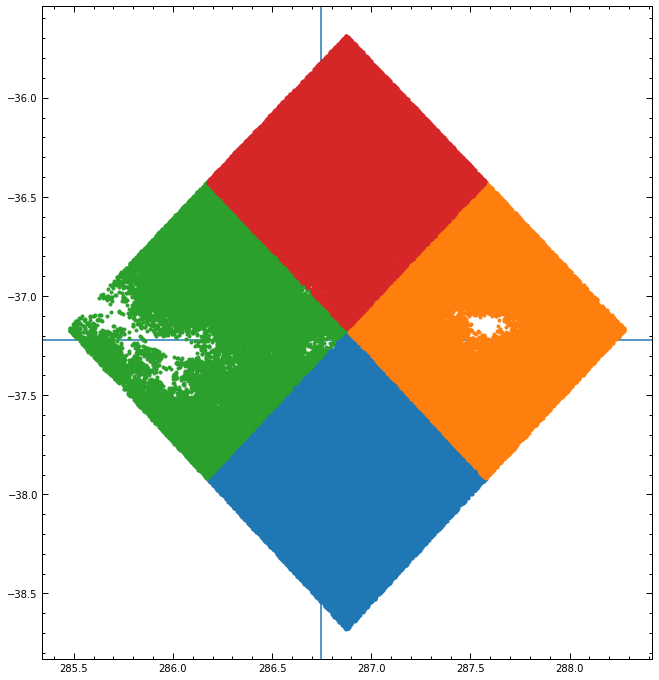

In [105]:
#my_instrument = lvmguiding.InstrumentParameters()
#my_instrument.outer_search_radius = 0.1#

my_instrument = lvmguiding.InstrumentParameters()
my_instrument.outer_search_radius = 1.1*np.sqrt(2)*width/2
my_instrument.mag_lim_lower = 21 #If you use a value higher than 17 here, make sure to remote-query the Gaia catalog
#remote_query = True


t0 = time.time()
data_combined = lvmguiding.get_cat_using_healpix2(c_cloud,plotflag=True,inst=my_instrument)
#ras,decs,dd_x_mm,dd_y_mm,chip_xxs,chip_yys,mags,culled_cat = lvmguiding.find_guide_stars(c_cloud,pa=0,recycled_cat=data_combined)
t1 = time.time()
print()
print("Duration using healpix preselection: {:.4f} s".format(t1-t0))


#t0 = time.time()
#data_combined = get_cat_using_healpix(c)
#ras,decs,dd_x_mm,dd_y_mm,chip_xxs,chip_yys,mags,culled_cat = lvmguiding.find_guide_stars(c_cloud,pa=0,plotflag=False,recycled_cat=culled_cat)#,inst=my_instrument
#t1 = time.time()
#print()
#print("Duration using preselected Gaia cat: {:.4f} s".format(t1-t0))
                                                                                         

    
    
t0 = time.time()
#data_combined = get_cat_using_healpix(c)
dd_x_mm,dd_y_mm,culled_cat2= lvmguiding.find_guide_stars(c_cloud,pa=0,plotflag=False,recycled_cat=data_combined,return_focal_plane_coords=True,inst=my_instrument)
t1 = time.time()
print()
print("Duration using preselected Gaia and only doing conversion to coordinates: {:.4f} s".format(t1-t0))
print("There are {} sources in the catalog".format(len(culled_cat2)))

second_stage_mag_lim = 99
culled_cat2 = culled_cat2[culled_cat2["phot_g_mean_mag"]<second_stage_mag_lim]
print("There are {} sources in the catalog".format(len(culled_cat2)))


In [106]:
# Define the IFU, it has to be doubled checked whether the used lens radius is alright and whether the IFU lib produces the correct results

my_ifu = IFU.IFU(4) 
lens_radii = 0.315/2 * np.ones_like(my_ifu.lensx) #This comes from PDR Document, Figure 4

In [107]:
ifu_point_list = []

for i in range(len(my_ifu.lensx)):
    current_x = my_ifu.lensx[i]
    current_y = my_ifu.lensy[i]
    
    ifu_point_list.append((current_x,current_y))


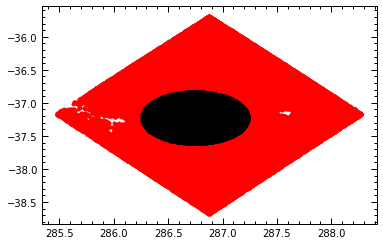

In [108]:
fig,ax = plt.subplots()
ax.plot(data_combined["ra"],data_combined["dec"],"r.")
ax.plot(culled_cat2["ra"],culled_cat2["dec"],"k.")

In [109]:
my_instrument.outer_search_radius

0.3889087296526012

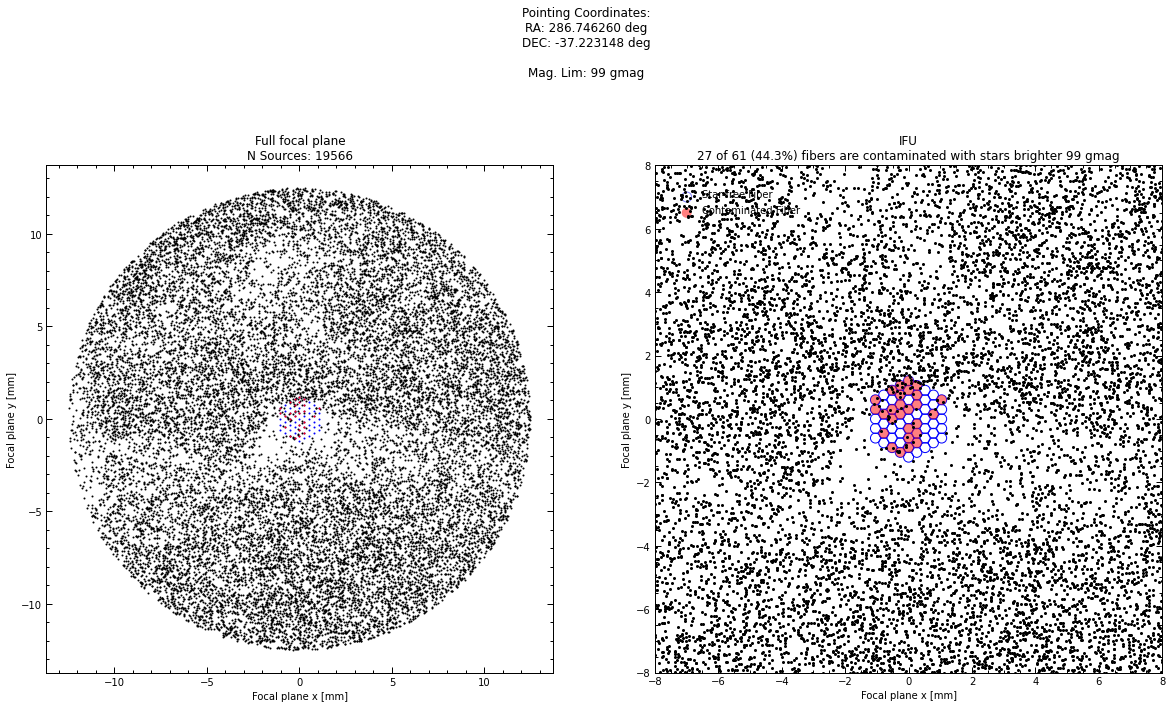

In [110]:
plotflag= True

dd_x_mm,dd_y_mm,culled_cat= lvmguiding.find_guide_stars(c_cloud,pa=0,plotflag=False,recycled_cat=culled_cat2,return_focal_plane_coords=True,inst=my_instrument)

nmax=10
data_dict={}
data_dict["x"] = dd_x_mm#[selection_mag]#.filled() 
data_dict["y"] = dd_y_mm#[selection_mag]#.filled() 
data_dict["m"] = culled_cat["phot_g_mean_mag"]#[selection_mag]
m_array = np.concatenate((np.array(data_dict["m"]),np.array([float("nan")])))
#print("Creating Tree...")
t0 = time.time()
#xy_list = np.vstack((dd_x_mm[selection_mag].filled(),dd_y_mm[selection_mag].filled())).T
xy_list = np.vstack((data_dict["x"],data_dict["y"])).T
YourTreeName = scipy.spatial.cKDTree(xy_list, leafsize=100)
t1 = time.time()
#print("... done! Time: {:.4f} s".format(t1-t0))



query_result = YourTreeName.query(ifu_point_list, k=nmax, distance_upper_bound=lens_radii[0])#

contaminated = np.isfinite(query_result[0][:,0])

current_r = lens_radii[0]

if plotflag:
    fig,(ax1,ax2) = plt.subplots(figsize=(20,12),ncols=2)
    fig.suptitle("Pointing Coordinates:\nRA: {:.6f}\nDEC: {:.6f}\n\nMag. Lim: {} gmag".format(c_cloud.ra,c_cloud.dec,second_stage_mag_lim))
    ax1.set_title("Full focal plane\nN Sources: {}".format(len(dd_x_mm)))


    ax1.set_xlabel("Focal plane x [mm]")
    ax1.set_ylabel("Focal plane y [mm]")
    ax2.set_xlabel("Focal plane x [mm]")
    ax2.set_ylabel("Focal plane y [mm]")

    ax1.plot(dd_x_mm,dd_y_mm,"ko",ms=1)
    ax1.plot(my_ifu.lensx,my_ifu.lensy,"bo",ms=1)
    ax1.plot(np.array(my_ifu.lensx)[contaminated],np.array(my_ifu.lensy)[contaminated],"ro",ms=1)
    ax1.set_aspect("equal")


    ax2.set_xlim(-8,8)
    ax2.set_ylim(-8,8)
    ax2.set_aspect("equal")

    patches = [plt.Circle(center, size) for center, size in zip(np.stack((my_ifu.lensx,my_ifu.lensy),axis=1),lens_radii)]

    patches_contaminated = [plt.Circle(center,size) for center, size in zip(np.stack((np.array(my_ifu.lensx)[contaminated],np.array(my_ifu.lensy)[contaminated]),axis=1),lens_radii[contaminated])]


    #
    coll = matplotlib.collections.PatchCollection(patches, facecolors='none',edgecolor="b")
    coll2 = matplotlib.collections.PatchCollection(patches_contaminated, facecolors='r',alpha=0.5)
    ax2.add_collection(coll)
    ax2.add_collection(coll2)

    ax2.plot(dd_x_mm,dd_y_mm,"ko",ms=2)
    #ax2.plot(dd_x_mm[selection_mag],dd_y_mm[selection_mag],"ko",ms=4)


    ax2.set_title("IFU\n{} of {} ({:.1f}%) fibers are contaminated with stars brighter {} gmag".format(np.sum(contaminated),len(contaminated),100*np.sum(contaminated)/len(contaminated),second_stage_mag_lim))

    circle = plt.Circle((-7,7),current_r,facecolor="none",edgecolor="b",alpha=0.5)
    ax2.add_patch(circle)
    circle = plt.Circle((-7,6.5),current_r,facecolor="r",alpha=0.5)
    ax2.add_patch(circle)
    
    #circle = plt.Circle((0,0),1.4,facecolor="r",alpha=0.5)
    #ax2.add_patch(circle)
    
    ax2.text(-6.5,7,"Star-free Fiber")#.format(maglim))
    ax2.text(-6.5,6.5,"Contaminated Fiber")#.format(maglim)
    
fig.savefig("irdc_results/{:09d}_fiber_view.png".format(irdc_identifier),dpi=200,bbox_inches="tight")

In [111]:
my_instrument.mag_lim_lower = 21

In [112]:

ratios = []

combined_neighbour_array = []

my_instrument2 = my_instrument
my_instrument2.upper_search_radius = 0.1

for index,c in enumerate(coordinate_list):
    dd_x_mm,dd_y_mm,culled_cat= lvmguiding.find_guide_stars(c,pa=0,plotflag=False,recycled_cat=culled_cat2,return_focal_plane_coords=True,inst=my_instrument2)
    
    nmax=10
    data_dict={}
    data_dict["x"] = dd_x_mm#[selection_mag]#.filled() 
    data_dict["y"] = dd_y_mm#[selection_mag]#.filled() 
    data_dict["m"] = culled_cat["phot_g_mean_mag"]#[selection_mag]
    m_array = np.concatenate((np.array(data_dict["m"]),np.array([float("nan")])))
    #print("Creating Tree...")
    t0 = time.time()
    #xy_list = np.vstack((dd_x_mm[selection_mag].filled(),dd_y_mm[selection_mag].filled())).T
    xy_list = np.vstack((data_dict["x"],data_dict["y"])).T
    YourTreeName = scipy.spatial.cKDTree(xy_list, leafsize=100)
    t1 = time.time()
    #print("... done! Time: {:.4f} s".format(t1-t0))
    
    
    
    query_result = YourTreeName.query(ifu_point_list, k=nmax, distance_upper_bound=lens_radii[0])#
    
    contaminated = np.isfinite(query_result[0][:,0])
    
    m_neighbours = m_array[query_result[1]]
    flux_neighbours = 10**(-0.4*m_neighbours)
    flux_combined = np.nansum(flux_neighbours,axis=1)
    m_combined = -2.5*np.log10(flux_combined)
    
    combined_neighbour_array.append(m_combined)
    
    #print("Ratio of contaminated pixels: ",np.sum(contaminated)/len(contaminated))
    ratios.append(np.sum(contaminated)/len(contaminated))
    
    print(index,len(coordinate_list),end="\r")
    
print()

/home/haeberle/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log10


22499 22500250022500


In [113]:
print(irdc_r)

0.09833610277777778


In [114]:
coordinate_list[min_index].ra.value

286.9042924042149

In [131]:
min_index = np.argmin(image[indices_in_radius])

In [132]:
coordinate_list.ra.value[indices_in_radius.flatten()][min_index]

286.71886771660274

In [133]:
best_xx = xx[indices_in_radius][min_index]

Maglim:    10.000000 Cont:     0.000000 Best RA:   286.718868 Best DEC:   -37.318786 Best dx:    -0.027392 Best dy:    -0.095638
Maglim:    11.000000 Cont:     0.000000 Best RA:   286.718868 Best DEC:   -37.318786 Best dx:    -0.027392 Best dy:    -0.095638
Maglim:    12.000000 Cont:     0.000000 Best RA:   286.718868 Best DEC:   -37.318786 Best dx:    -0.027392 Best dy:    -0.095638
Maglim:    13.000000 Cont:     0.000000 Best RA:   286.718868 Best DEC:   -37.318786 Best dx:    -0.027392 Best dy:    -0.095638
Maglim:    14.000000 Cont:     0.000000 Best RA:   286.765224 Best DEC:   -37.318786 Best dx:     0.018964 Best dy:    -0.095638
Maglim:    15.000000 Cont:     0.000000 Best RA:   286.689368 Best DEC:   -37.308718 Best dx:    -0.056892 Best dy:    -0.085570
Maglim:    16.000000 Cont:     0.000000 Best RA:   286.664083 Best DEC:   -37.295296 Best dx:    -0.082177 Best dy:    -0.072148
Maglim:    17.000000 Cont:     0.000000 Best RA:   286.710439 Best DEC:   -37.251671 Best dx:    

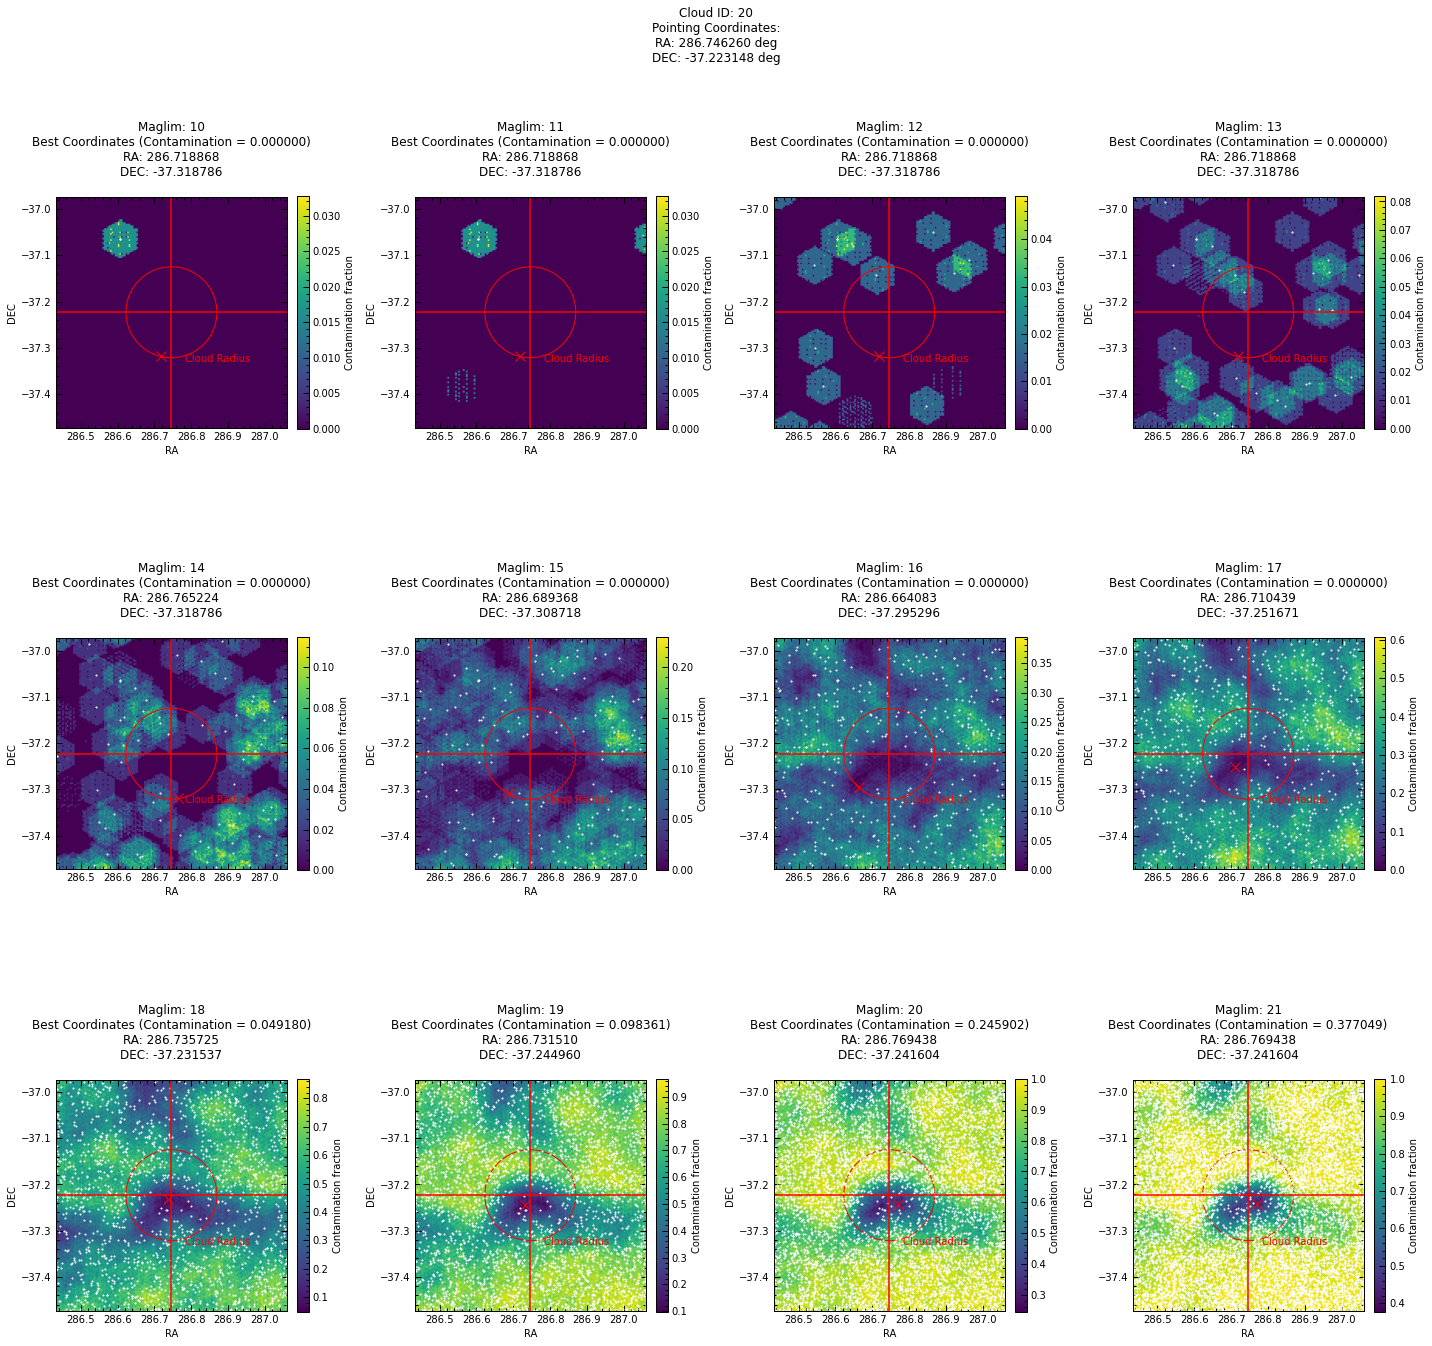

In [138]:
min_mags = np.arange(10,22,1)

fig,axarr = plt.subplots(figsize=(20,20),ncols=4,nrows=3)

fig.suptitle("Cloud ID: {}\nPointing Coordinates:\nRA: {:.6f}\nDEC: {:.6f}\n".format(irdc_identifier,c_cloud.ra,c_cloud.dec))
    

outfile = open("irdc_results/{:09d}_contamination.txt".format(irdc_identifier),"w")
    

for index,ax in enumerate(axarr.flatten()):
    mag_lim = min_mags[index]
    
    
    
    
    
   
    
    image = np.reshape(np.sum(np.array(combined_neighbour_array)<mag_lim,axis=1),xx.shape)/len(ifu_point_list)
    
    indices_in_radius = (xx*np.cos(np.deg2rad(dec_irdc)))**2+yy**2 < irdc_r**2
    
    min_index = np.argmin(image[indices_in_radius])
    
    best_cont = image[indices_in_radius][min_index]
    best_xx = xx[indices_in_radius][min_index]
    best_yy = yy[indices_in_radius][min_index]
    best_ra = coordinate_list.ra.value[indices_in_radius.flatten()][min_index]
    best_dec = coordinate_list.dec.value[indices_in_radius.flatten()][min_index]
    best_c = image[indices_in_radius][min_index]
    
    print("Maglim: {:12.6f} Cont: {:12.6f} Best RA: {:12.6f} Best DEC: {:12.6f} Best dx: {:12.6f} Best dy: {:12.6f}".format(mag_lim,best_cont,best_ra,best_dec,best_xx,best_yy))
    outfile.write("{:12.6f} {:12.6f} {:12.6f} {:12.6f} {:12.6f} {:12.6f}\n".format(mag_lim,best_cont,best_ra,best_dec,best_xx,best_yy))
    ax.set_title("Maglim: "+str(mag_lim)+"\nBest Coordinates (Contamination = {:2f})\nRA: {:.6f}\nDEC: {:.6f}\n".format(best_cont,best_ra,best_dec))
    #image[indices_in_radius] = float("nan")
    
    myplot = ax.imshow(image,origin="lower",extent=(ras2.min(),ras2.max(),decs2.min(),decs2.max()),aspect=1/np.cos(np.deg2rad(dec_irdc)))
    mycb = fig.colorbar(myplot,ax=ax,fraction=0.046, pad=0.04)
    
    ax.plot(best_ra,best_dec,"rx",ms=10)
    
    mycb.set_label("Contamination fraction")
    
    ax.set_xlim(ras2.min(),ras2.max())
    ax.set_ylim(decs2.min(),decs2.max())
    
    ax.plot(culled_cat2["ra"][culled_cat2["phot_g_mean_mag"]<mag_lim],culled_cat2["dec"][culled_cat2["phot_g_mean_mag"]<mag_lim],"w.",ms=2)
    ax.axhline(dec_irdc,color="r")
    ax.axvline(ra_irdc,color="r")

    #ax2.axvline(ra_irdc-irdc_r/np.cos(np.deg2rad(dec_irdc)),color="r")
    #ax2.axvline(ra_irdc+irdc_r/np.cos(np.deg2rad(dec_irdc)),color="r")

    ax.set_xlabel("RA")
    ax.set_ylabel("DEC")
    
    my_ellipse = Ellipse(xy=(ra_irdc,dec_irdc),height = 2*irdc_r,width=2*irdc_r/np.cos(np.deg2rad(dec_irdc)),facecolor="None",edgecolor="r")
    ax.add_patch(my_ellipse)
    
    ax.text(ra_irdc+0.1/np.cos(np.deg2rad(dec_irdc)),dec_irdc-0.1,"Cloud Radius",ha="center",va="center",color="r")
outfile.close()
fig.tight_layout()
    
#fig.savefig("/home/haeberle/exchange/example_cloud_0_not_prominent.png",dpi=200,bbox_inches="tight",facecolor="w",backgroundcolor="w")
    
if False:    
    #fig,ax2 = plt.subplots(figsize=(10,10))

    #ax1.axhline(irdc_data[irdc_index,2],color="r")
    #ax1.axvline(irdc_data[irdc_index,1],color="r")



    #myplot = ax1.scatter(ras2,decs2,c=ratios,s=20,marker=".")

    ax2.plot(culled_cat2["ra"],culled_cat2["dec"],"r.",ms=2)

    #ax1.set_xlim(ras2.min(),ras2.max())
    #ax1.set_ylim(decs2.min(),decs2.max())
    #fig.colorbar(myplot,ax=ax1)
    myplot1 = ax1.imshow(image1,origin="lower",extent=(ras2.min(),ras2.max(),decs2.min(),decs2.max()),aspect=1/np.cos(np.deg2rad(dec_irdc)))
    myplot2 = ax2.imshow(image2,origin="lower",extent=(ras2.min(),ras2.max(),decs2.min(),decs2.max()),aspect=1/np.cos(np.deg2rad(dec_irdc)))
    #my_circle = plt.Circle(xy=(ra_irdc,dec_irdc),radius=irdc_r,facecolor="None",edgecolor="r")
    my_ellipse = Ellipse(xy=(ra_irdc,dec_irdc),height = 2*irdc_r,width=2*irdc_r/np.cos(np.deg2rad(dec_irdc)),facecolor="None",edgecolor="r")

    my_ellipse2 = Ellipse(xy=(ra_irdc-0.3/np.cos(np.deg2rad(dec_irdc)),dec_irdc+0.3),height = 2*0.0436,width=2*0.0436/np.cos(np.deg2rad(dec_irdc)),facecolor="w",edgecolor="w",alpha=0.7)
    ax1.text(ra_irdc-0.3/np.cos(np.deg2rad(dec_irdc)),dec_irdc+0.3,"IFU\nSize",ha="center",va="center")


    ax1.text(ra_irdc+0.1/np.cos(np.deg2rad(dec_irdc)),dec_irdc-0.1,"Cloud Radius",ha="center",va="center",color="r")

    #mycb = fig.colorbar(myplot2,ax=ax2)
    #mycb.set_label("Contamination fraction")
    fig.colorbar(myplot1,ax=ax1)
    fig.colorbar(myplot2,ax=ax2)

    #ax2.add_patch(my_circle)
    ax1.add_patch(my_ellipse)
    ax1.add_patch(my_ellipse2)

    ax1.axhline(dec_irdc,color="r")
    ax1.axvline(ra_irdc,color="r")

    #ax2.axvline(ra_irdc-irdc_r/np.cos(np.deg2rad(dec_irdc)),color="r")
    #ax2.axvline(ra_irdc+irdc_r/np.cos(np.deg2rad(dec_irdc)),color="r")

    ax2.set_xlabel("RA")
    ax2.set_ylabel("DEC")

    #fig.savefig("/home/haeberle/exchange/example_cloud_5_maglim_12_highres.png",dpi=200,bbox_inches="tight")


In [116]:
min_index = np.argmin(np.reshape(np.sum(np.array(combined_neighbour_array)<mag_lim,axis=1),xx.shape)/len(ifu_point_list))

print(coordinate_list[min_index])
print(xx.flatten()[min_index])
print(yy.flatten()[min_index])

<SkyCoord (ICRS): (ra, dec) in deg
    (286.76943809, -37.24160438)>
0.023178085951519045
-0.018456375838926176


In [20]:
len(data_combined)

19485

<SkyCoord (ICRS): (ra, dec) in deg
    (265.796591, -28.938811)>
PA:  0
Using the full cat for the first position
PA:  60
PA:  120
PA:  180
PA:  240
PA:  300


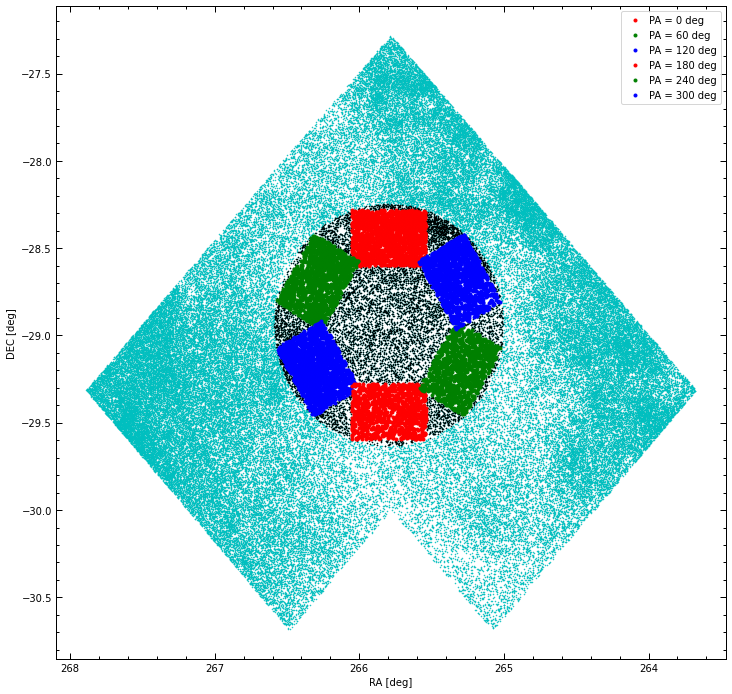

In [18]:

print(c)
color_array=["r","g","b","r","g","b"]


fig,ax = plt.subplots(figsize=(12,12))

ax.plot(data_combined["ra"],data_combined["dec"],"c.",ms=1)

for index,pa in enumerate([0,60,120,180,240,300]):
        print("PA: ",pa)
        if pa==0:
            print("Using the full cat for the first position")
            culled_cat=lvmguiding.cat_full
        ras,decs,dd_x_mm,dd_y_mm,chip_xxs,chip_yys,mags,culled_cat = lvmguiding.find_guide_stars(c,pa=pa,plotflag=False,recycled_cat=data_combined)
        
        if pa==0:
            ax.plot(culled_cat["ra"],culled_cat["dec"],"k.",ms=1)
        ax.plot(ras,decs,".",c=color_array[index],label="PA = "+str(pa)+" deg")
        
ax.legend()

ax.set_xlabel("RA [deg]")
ax.set_ylabel("DEC [deg]")
ax.invert_xaxis()

#fig.savefig("/home/haeberle/exchange/lvm/report/position_angles.png",bbox_inches="tight",facecolor="w",edgecolor="w",dpi=200)

In [44]:
my_instrument = lvmguiding.InstrumentParameters()

In [45]:
dd_x_mm.shape

(560,)

In [50]:
my_instrument = lvmguiding.InstrumentParameters()
my_instrument.mag_lim_lower = 17 #If you use a value higher than 17 here, make sure to remote-query the Gaia catalog
remote_query = False

In [54]:
len(data_combined)

19485

In [56]:
dd_x_mm,dd_y_mm,culled_cat = lvmguiding.find_guide_stars(c,pa=0,plotflag=False,return_focal_plane_coords=True,remote_catalog=remote_query,inst=my_instrument,recycled_cat=data_combined)

In [57]:
second_stage_mag_lim = my_instrument.mag_lim_lower #Adapt this if you want to change the maglim AFTER the catalog query

selection_mag = culled_cat["phot_g_mean_mag"] < second_stage_mag_lim
print("Number of sources in focal plane: ",len(dd_x_mm))
print("Stars that pass second stage mag selection: ",np.sum(selection_mag))

Number of sources in focal plane:  5645
Stars that pass second stage mag selection:  5645


In [58]:
# Define the IFU, it has to be doubled checked whether the used lens radius is alright and whether the IFU lib produces the correct results

my_ifu = IFU.IFU(4) 
lens_radii = 0.315/2 * np.ones_like(my_ifu.lensx) #This comes from PDR Document, Figure 4

In [70]:
import scipy.spatial
import matplotlib

In [71]:
nmax=10
data_dict={}
data_dict["x"] = dd_x_mm[selection_mag]#.filled() 
data_dict["y"] = dd_y_mm[selection_mag]#.filled() 
data_dict["m"] = culled_cat["phot_g_mean_mag"][selection_mag]
print("Creating Tree...")
t0 = time.time()
#xy_list = np.vstack((dd_x_mm[selection_mag].filled(),dd_y_mm[selection_mag].filled())).T
xy_list = np.vstack((data_dict["x"],data_dict["y"])).T
YourTreeName = scipy.spatial.cKDTree(xy_list, leafsize=100)
t1 = time.time()
print("... done! Time: {:.4f} s".format(t1-t0))

Creating Tree...
... done! Time: 0.0043 s


Neighbour search took  0.037s
3 of 61 (4.9%) fibers are contaminated with stars brighter 17 gmag


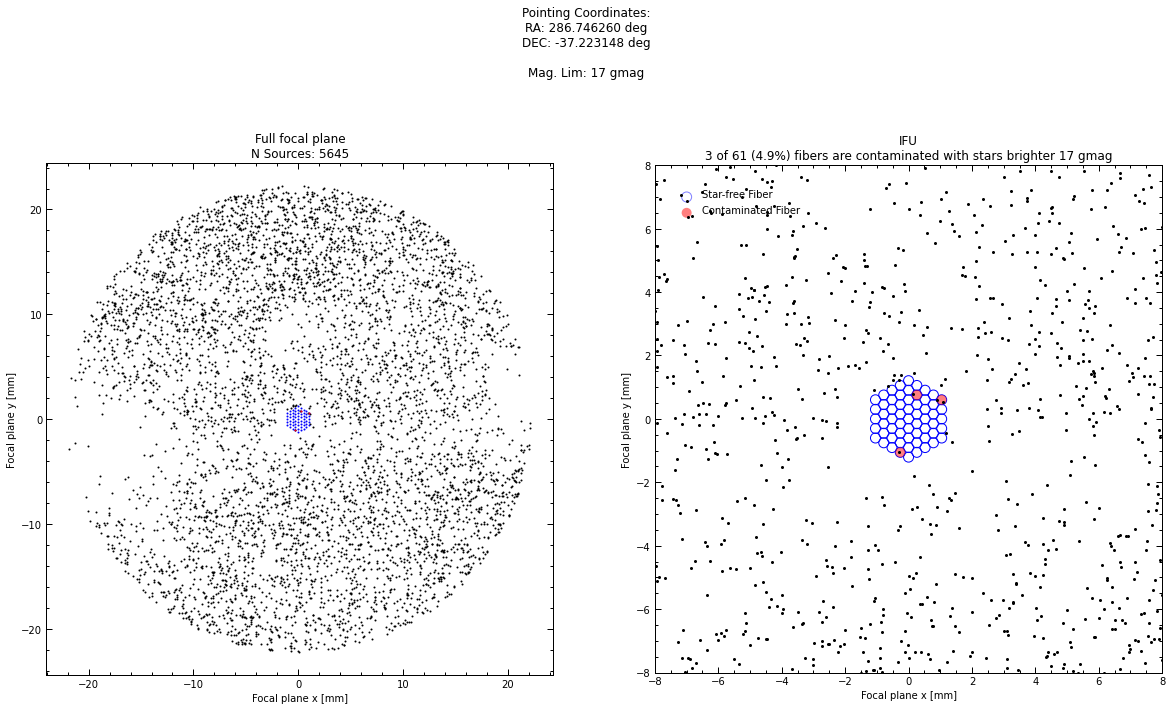

In [79]:
use_tree = False
plotflag = True

time0 = time.time()
contaminated = np.array(my_ifu.lensx) < -999
for i in range(len(my_ifu.lensx)):
    current_x = my_ifu.lensx[i]
    current_y = my_ifu.lensy[i]
    current_r = lens_radii[i]
    if use_tree:
        query_result = YourTreeName.query((current_x,current_y), k=nmax, distance_upper_bound=current_r)#
        x_neighbours = data_dict["x"][query_result[1][np.isfinite(query_result[0])]]
        y_neighbours = data_dict["y"][query_result[1][np.isfinite(query_result[0])]]
        m_neighbours = data_dict["m"][query_result[1][np.isfinite(query_result[0])]]
        
        #print("Fiber Nr.: {:3d} Nneighbours: {:3d}".format(i,len(m_neighbours)))
        if len(m_neighbours)>0:
            contaminated[i]=True
    else:
        d2 = (current_x-dd_x_mm[selection_mag])**2+(current_y-dd_y_mm[selection_mag])**2
        if d2.min() < current_r**2:
            contaminated[i]=True

        
            
time1 = time.time()

print("Neighbour search took {:6.2}s".format(time1-time0))
print("{} of {} ({:.1f}%) fibers are contaminated with stars brighter {} gmag".format(np.sum(contaminated),len(contaminated),100*np.sum(contaminated)/len(contaminated),second_stage_mag_lim))



if plotflag:
    fig,(ax1,ax2) = plt.subplots(figsize=(20,12),ncols=2)
    fig.suptitle("Pointing Coordinates:\nRA: {:.6f}\nDEC: {:.6f}\n\nMag. Lim: {} gmag".format(c.ra,c.dec,second_stage_mag_lim))
    ax1.set_title("Full focal plane\nN Sources: {}".format(len(dd_x_mm)))


    ax1.set_xlabel("Focal plane x [mm]")
    ax1.set_ylabel("Focal plane y [mm]")
    ax2.set_xlabel("Focal plane x [mm]")
    ax2.set_ylabel("Focal plane y [mm]")

    ax1.plot(dd_x_mm,dd_y_mm,"ko",ms=1)
    ax1.plot(my_ifu.lensx,my_ifu.lensy,"bo",ms=1)
    ax1.plot(np.array(my_ifu.lensx)[contaminated],np.array(my_ifu.lensy)[contaminated],"ro",ms=1)
    ax1.set_aspect("equal")


    ax2.set_xlim(-8,8)
    ax2.set_ylim(-8,8)
    ax2.set_aspect("equal")

    patches = [plt.Circle(center, size) for center, size in zip(np.stack((my_ifu.lensx,my_ifu.lensy),axis=1),lens_radii)]

    patches_contaminated = [plt.Circle(center,size) for center, size in zip(np.stack((np.array(my_ifu.lensx)[contaminated],np.array(my_ifu.lensy)[contaminated]),axis=1),lens_radii[contaminated])]


    #
    coll = matplotlib.collections.PatchCollection(patches, facecolors='none',edgecolor="b")
    coll2 = matplotlib.collections.PatchCollection(patches_contaminated, facecolors='r',alpha=0.5)
    ax2.add_collection(coll)
    ax2.add_collection(coll2)

    ax2.plot(dd_x_mm,dd_y_mm,"ko",ms=2)
    #ax2.plot(dd_x_mm[selection_mag],dd_y_mm[selection_mag],"ko",ms=4)


    ax2.set_title("IFU\n{} of {} ({:.1f}%) fibers are contaminated with stars brighter {} gmag".format(np.sum(contaminated),len(contaminated),100*np.sum(contaminated)/len(contaminated),second_stage_mag_lim))

    circle = plt.Circle((-7,7),current_r,facecolor="none",edgecolor="b",alpha=0.5)
    ax2.add_patch(circle)
    
    circle_irdc = plt.Circle((0,0),irdc_data[irdc_index,7]/my_instrument.image_scale,facecolor="none",edgecolor="r")
    ax2.add_patch(circle_irdc)
    circle = plt.Circle((-7,6.5),current_r,facecolor="r",alpha=0.5)
    ax2.add_patch(circle)
    ax2.text(-6.5,7,"Star-free Fiber")#.format(maglim))
    ax2.text(-6.5,6.5,"Contaminated Fiber")#.format(maglim))






#fig.savefig("dark_patch_stellar_contamination.png",dpi=200,bbox_inches="tight",facecolor="w")

In [77]:
my_instrument.image_scale

8.92

In [80]:
irdc_data[irdc_index,7]/my_instrument.image_scale

39.687216367713006

## Create a synthetic image

In [ ]:
ras,decs,dd_x_mm,dd_y_mm,chip_xxs,chip_yys,mags,culled_cat = lvmguiding.find_guide_stars(c,pa=0,plotflag=False)

In [ ]:
standard_instrument = lvmguiding.InstrumentParameters()

In [ ]:
my_image = lvmguiding.make_synthetic_image(chip_x=chip_xxs,
                                           chip_y=chip_yys,
                                          gmag=mags,
                                          inst =standard_instrument,
                                          exp_time=5,
                                          seeing_arcsec=3.5,
                                          sky_flux=15)

In [ ]:
combined= my_image
fig,ax4 = plt.subplots(figsize=(12,8))

vmin4 = np.percentile(combined,25)
vmax4 = np.percentile(combined,99.5)

my_plot4 = ax4.imshow(combined,origin="lower",norm=LogNorm(vmin=np.max([vmin4,1]), vmax=vmax4))


#if np.sum(sn>5) < 10:
#    ax4.set_title("Combined (Bias + Readout Error + Noisy Background + Noisy Stars)\nBrightest star (red): gmag = {:.2f} ; F = {:.1f} e-/s\nPotentially saturated pixels (Ne- > 20000): {}\nWhite circle around all stars with S/N > 5 (N = {})".format(np.min(gmag),gaia_flux[np.argmin(gmag)],np.sum(combined>20000),np.sum(sn>5)))
#    ax4.plot(x_position[sn>5],y_position[sn>5],"o",ms=40,markerfacecolor="none",markeredgecolor="w",label="gmag < 12")
#else:
#    ax4.set_title("Combined (Bias + Readout Error + Noisy Background + Noisy Stars)\nPointing: {}  Texp: {} s\n{} of {} stars have a S/N > 5\nBrightest star (red): gmag = {:.2f} ; F = {:.1f} e-/s\nPotentially saturated pixels (Ne- > 20000): {}\n".format(pointing_string,exp_time,np.sum(sn>5),len(gmag),np.min(gmag),gaia_flux[np.argmin(gmag)],np.sum(combined>20000)))
#ax4.plot(x_position[np.argmin(gmag)],y_position[np.argmin(gmag)],"o",ms=20,markerfacecolor="none",markeredgecolor="r",label="gmag < 12")
plt.colorbar(my_plot4,ax=ax4,fraction=0.046, pad=0.04)
#plt.colorbar(my_plot4,ax=ax,fraction=0.046, pad=0.04)
#ax4.legend()

fig.tight_layout()

#filename = "/home/haeberle/exchange/lvm/report/pointing_"+pointing_string+"_{:d}ms.png".format(int(1000*exp_time))
#fig.suptitle()
#fig.savefig("/home/haeberle/exchange/lvm/report/example_crowded_field.png",dpi=200,bbox_inches="tight",edgecolor="white",facecolor="white")
#fig.savefig(filename,dpi=200,bbox_inches="tight",edgecolor="white",facecolor="white") 